# Simple CNN Model for Malaria Image Detection
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

![Malario](https://images3.memedroid.com/images/UPLOADED68/5c6b111fb1011.jpeg)

# 1.1 Data Preproc



1.1.1 Pseudo-Code

---

1. EDA 
2. Preproc Pipeline
3. Model Pipeline
4. Combine Pipeline
5. Train model on subset

---

In [28]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# imports 

import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

## 1.2 EDA (lite)

In [35]:
raw_data_dir = "/content/drive/My Drive/cell_images"

os.listdir(raw_data_dir)

['Parasitized', 'Uninfected']

In [36]:
parasitized = os.listdir(f"{raw_data_dir}/Parasitized")
uninfected = os.listdir(f"{raw_data_dir}/Uninfected")

# I know its hardcoded ...

In [37]:
parasitized[1]

'C182P143NThinF_IMG_20151201_172257_cell_165.png'

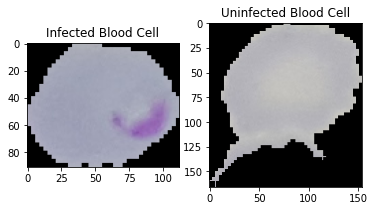

In [38]:
im1 = mpimg.imread(f"{raw_data_dir}/Parasitized/{parasitized[5]}")
im2 = mpimg.imread(f"{raw_data_dir}/Uninfected/{uninfected[5]}")
plt.subplot(1,2,1)
plt.imshow(im1)
plt.title("Infected Blood Cell")
plt.subplot(1,2,2)
plt.imshow(im2)
plt.title("Uninfected Blood Cell");

In [39]:
print(len(parasitized))
print("+---+")
print(len(uninfected))
print("+---+")
print(f"Ratio:{len(parasitized)/len(uninfected)}")

13780
+---+
13790
+---+
Ratio:0.9992748368382887


Dataset is balanced (Keep in mind, that in real life the ratio variates, but can be approximated with 1/1)

## 1.3 Dataset Creation and Split

In [40]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 16
height = 128
width = 128

data_train = image_dataset_from_directory(raw_data_dir, batch_size=batch_size, validation_split=0.2,image_size=(height, width), seed=42, subset="training")

Found 27568 files belonging to 2 classes.
Using 22055 files for training.


In [41]:
data_val = image_dataset_from_directory(raw_data_dir, batch_size=batch_size, validation_split=0.2, image_size=(height, width), seed=42, subset="validation")

Found 27568 files belonging to 2 classes.
Using 5513 files for validation.


In [42]:
class_names = data_train.class_names

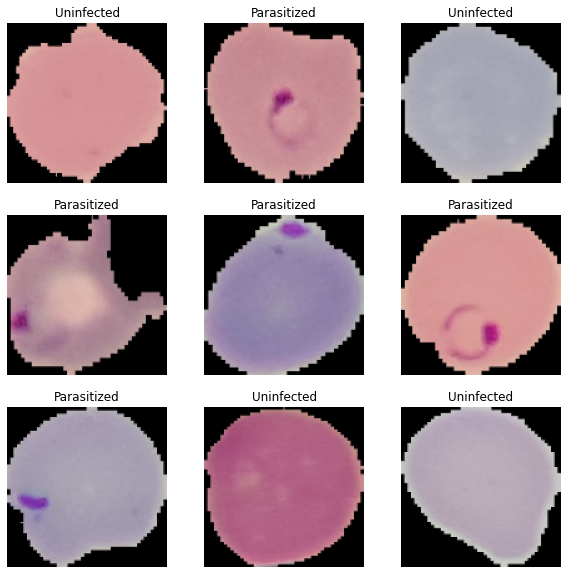

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2 Modeling

---

## 2.1 Baseline model

In [44]:
# Since the Dataset is balanced a baseline model would be guess one class on a 50% probabiity

base_acc = 0.5

# Model needs to beat 0.5 acc

## 2.2 Simple CNN Model

In [56]:
from tensorflow.keras import Sequential

model = Sequential()
model.add(layers.Rescaling(1/255,input_shape=(128,128,3)))
model.add(layers.Conv2D(16,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["Accuracy","Recall"])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(data_train, validation_data=data_val, epochs=30, verbose=1, callbacks=es)

Epoch 1/30
1379/1379 [==============================] - 84s 60ms/step - loss: 0.4127 - Accuracy: 0.8059 - recall: 0.8512 - val_loss: 0.1614 - val_Accuracy: 0.9412 - val_recall: 0.9506
Epoch 2/30
1379/1379 [==============================] - 81s 59ms/step - loss: 0.1785 - Accuracy: 0.9431 - recall: 0.9569 - val_loss: 0.1351 - val_Accuracy: 0.9559 - val_recall: 0.9835
Epoch 3/30
1379/1379 [==============================] - 79s 57ms/step - loss: 0.1657 - Accuracy: 0.9494 - recall: 0.9637 - val_loss: 0.1330 - val_Accuracy: 0.9576 - val_recall: 0.9807
Epoch 4/30
1379/1379 [==============================] - 80s 57ms/step - loss: 0.1515 - Accuracy: 0.9523 - recall: 0.9672 - val_loss: 0.1385 - val_Accuracy: 0.9519 - val_recall: 0.9825
Epoch 5/30
1379/1379 [==============================] - 80s 58ms/step - loss: 0.1450 - Accuracy: 0.9546 - recall: 0.9676 - val_loss: 0.1242 - val_Accuracy: 0.9579 - val_recall: 0.9782
Epoch 6/30
1379/1379 [==============================] - 78s 56ms/step - loss: 0.

In [58]:
def plotLearningCurve(history):
    plt.plot(history.history['Accuracy'])
    plt.plot(history.history['val_Accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

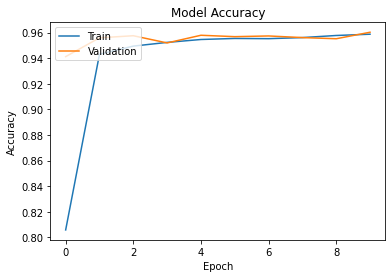

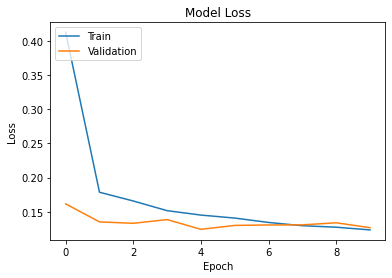

In [60]:
plotLearningCurve(history)